# Students:

### Le Hoang Sang

### Vu Dinh Chuong

In [158]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
import torch.optim as optim
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import MultiOutputMixin, RegressorMixin, BaseEstimator, _fit_context
from abc import ABCMeta, abstractmethod
from sklearn.utils.validation import check_is_fitted, _check_sample_weight
from sklearn.utils.extmath import safe_sparse_dot
from numbers import Integral

# CLean data

In [159]:
def clean_data(df):
    print("Initial data information:")
    print(df.info())

    # Remove unnecessary columns (if there are columns named 'Unnamed')
    df = df.loc[:, ~df.columns.get_level_values(1).str.contains('^Unnamed')]

    # Handle the 'timestamp' column (if present)
    if ('timestamp', '') in df.columns:
        # Convert to datetime format
        df[('timestamp', '')] = pd.to_datetime(df[('timestamp', '')], errors='coerce')  
        
        # Remove rows with missing timestamp values
        df = df.dropna(subset=[('timestamp', '')]) 

    # Fill missing values using forward fill and backward fill methods
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Normalize 'close' values between 0 and 1 if present
    if ('close', '') in df.columns:
        df[('close', '')] = (df[('close', '')] - df[('close', '')].min()) / (df[('close', '')].max() - df[('close', '')].min())

    # Print out the data after cleaning
    print("Data after cleaning:")
    print(df.head())

    return df


### Explain forward fill and backward fill methods

#### FFill
data = [1, 2, NaN, NaN, 5]

filled_data = [1, 2, 2, 2, 5]

=> 'NaN' values replaced with the previous valid value (2).

#### BFill
data = [1, 2, NaN, NaN, 5]

filled_data = [1, 2, 5, 5, 5]

=>'NaN' values replaced with the next valid value (5).

## Explain Min-max Normalization

normalized_value= (max_value − min_value) / (original_value − min_value)

​
Example:

close = [50, 55, 60, 65, 70]

min(x)=50
max(𝑥)=70

With value 60:
x_normalized = (60−50) / (70−50) = 10 / 20 = 0.5

# Create features

In the DataFrame: The dataset we re working with a MultiIndex data structure, where the first level of the index (such as 'A', 'AAL', etc.) represents the stock symbol, and the second level represents the attributes of the stock (such as 'close', 'open', 'high', etc.).

'A' is a stock symbol representing a specific company or asset.

Other symbols like 'AAL', 'ZION', etc., represent different companies or assets.

Why set symbol = 'A'?

In our code, setting symbol = 'A' focuses on the data of a specific company or asset. 

Since our DataFrame contains data for multiple stock symbols, we need to specify which stock symbol we want to use for feature generation.

In [160]:
def create_features(df):
    df_features = df.copy()

    print("Column names in the DataFrame:", df_features.columns)

    # Define the symbol you want to work with (e.g., 'A', 'AAL', etc.)
    symbol = 'A'

    # Define the columns for the selected stock symbol
    numeric_cols = [(symbol, 'open'), (symbol, 'high'), (symbol, 'low'), (symbol, 'close'), (symbol, 'volume')]

    # Check if these columns exist in the DataFrame
    existing_cols = [col for col in numeric_cols if col in df_features.columns]

    if not existing_cols:
        raise ValueError("Required numeric columns not found in the DataFrame.")

    # Convert the necessary columns to numeric type
    df_features[existing_cols] = df_features[existing_cols].apply(pd.to_numeric, errors='coerce')

    # Remove rows with NaN values after conversion
    df_features = df_features.dropna()

    # Create features if the necessary columns exist
    if (symbol, 'close') in df_features.columns:
        df_features[(symbol, 'return')] = df_features[(symbol, 'close')].pct_change()
        df_features[(symbol, 'ma7')] = df_features[(symbol, 'close')].rolling(window=7).mean()
        df_features[(symbol, 'ma21')] = df_features[(symbol, 'close')].rolling(window=21).mean()
        df_features[(symbol, 'volatility')] = df_features[(symbol, 'close')].rolling(window=7).std()
    
    if (symbol, 'open') in df_features.columns and (symbol, 'close') in df_features.columns:
        df_features[(symbol, 'open_close_ratio')] = df_features[(symbol, 'open')] / df_features[(symbol, 'close')]
    
    if (symbol, 'high') in df_features.columns and (symbol, 'low') in df_features.columns:
        df_features[(symbol, 'high_low_ratio')] = df_features[(symbol, 'high')] / df_features[(symbol, 'low')]

    # Remove rows with NaN values due to calculations
    df_features = df_features.dropna()  

    print("DataFrame with new features:")
    print(df_features.head())

    return df_features

# Plot data

In [161]:
def plot_features(df_features, symbol='A'):
    # Ensure symbol exists in the DataFrame
    if symbol not in df_features.columns.get_level_values(0):
        raise ValueError(f"Symbol '{symbol}' not found in DataFrame columns.")

    # Plot the 'close' price
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'close')], label=f'{symbol} Close Price', color='b')
    plt.title(f'{symbol} Close Price Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Plot the 7-day and 21-day moving averages
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'ma7')], label=f'{symbol} MA7', color='g')
    plt.plot(df_features.index, df_features[(symbol, 'ma21')], label=f'{symbol} MA21', color='r')
    plt.title(f'{symbol} 7-day and 21-day Moving Averages')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Plot the volatility (7-day rolling standard deviation)
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'volatility')], label=f'{symbol} Volatility (7-day)', color='purple')
    plt.title(f'{symbol} Volatility (7-day rolling std)')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

    # Plot the open/close ratio
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'open_close_ratio')], label=f'{symbol} Open/Close Ratio', color='orange')
    plt.title(f'{symbol} Open/Close Ratio Over Time')
    plt.xlabel('Time')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()

    # Plot the high/low ratio
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'high_low_ratio')], label=f'{symbol} High/Low Ratio', color='brown')
    plt.title(f'{symbol} High/Low Ratio Over Time')
    plt.xlabel('Time')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()

# Run flow

In [162]:
df = pd.read_csv('dataset.csv', index_col=0, header=[0, 1]).sort_index(axis=1)

In [163]:
df_cleaned = clean_data(df)



Initial data information:
<class 'pandas.core.frame.DataFrame'>
Index: 43146 entries, 2017-09-11 09:30:00 to 2018-02-16 15:59:00
Columns: 2510 entries, ('A', 'close') to ('ZTS', 'volume')
dtypes: float64(2510)
memory usage: 826.6+ MB
None
Data after cleaning:
                         A                                      AAL         \
                     close   high      low     open   volume  close   high   
timestamp                                                                    
2017-09-11 09:30:00  65.46  65.50  65.4100  65.5000  29852.0  44.01  44.05   
2017-09-11 09:31:00  65.46  65.50  65.4100  65.5000  29852.0  44.25  44.25   
2017-09-11 09:32:00  65.66  65.66  65.4604  65.4604   3435.0  44.27  44.32   
2017-09-11 09:33:00  65.69  65.70  65.6200  65.6700    700.0  44.34  44.46   
2017-09-11 09:34:00  65.88  65.88  65.6800  65.6900   2814.0  44.24  44.36   

                                              ...   ZION                       \
                         low   ope

In [164]:
# Get 6 first columns
df_features = create_features(df_cleaned.iloc[:, :5])


Column names in the DataFrame:

 MultiIndex([('A',  'close'),
            ('A',   'high'),
            ('A',    'low'),
            ('A',   'open'),
            ('A', 'volume')],
           )
DataFrame with new features:
                          A                                             \
                      close    high     low     open  volume    return   
timestamp                                                                
2017-09-11 09:50:00  65.800  65.820  65.790  65.8124  2452.0  0.000000   
2017-09-11 09:51:00  65.810  65.830  65.810  65.8200  2201.0  0.000152   
2017-09-11 09:52:00  65.850  65.850  65.820  65.8200  1100.0  0.000608   
2017-09-11 09:53:00  65.750  65.820  65.750  65.8200  4955.0 -0.001519   
2017-09-11 09:54:00  65.765  65.765  65.765  65.7650   700.0  0.000228   

                                                                       \
                           ma7       ma21 volatility open_close_ratio   
timestamp                                                               

In [165]:
# Get data for the symbol 'A'
df1 = df_features.loc[:, 'A']
# Get first 6 columns
df1 = df1.iloc[:, :5]
df1

,close,high,low,open,volume
timestamp,,,,,
2017-09-11 09:50:00,65.800,65.820,65.790,65.8124,2452.0
2017-09-11 09:51:00,65.810,65.830,65.810,65.8200,2201.0
2017-09-11 09:52:00,65.850,65.850,65.820,65.8200,1100.0
2017-09-11 09:53:00,65.750,65.820,65.750,65.8200,4955.0
2017-09-11 09:54:00,65.765,65.765,65.765,65.7650,700.0
...,...,...,...,...,...
2018-02-16 15:55:00,72.125,72.130,72.090,72.0950,17309.0
2018-02-16 15:56:00,72.070,72.125,72.070,72.1250,15441.0
2018-02-16 15:57:00,72.060,72.100,72.050,72.0700,18096.0


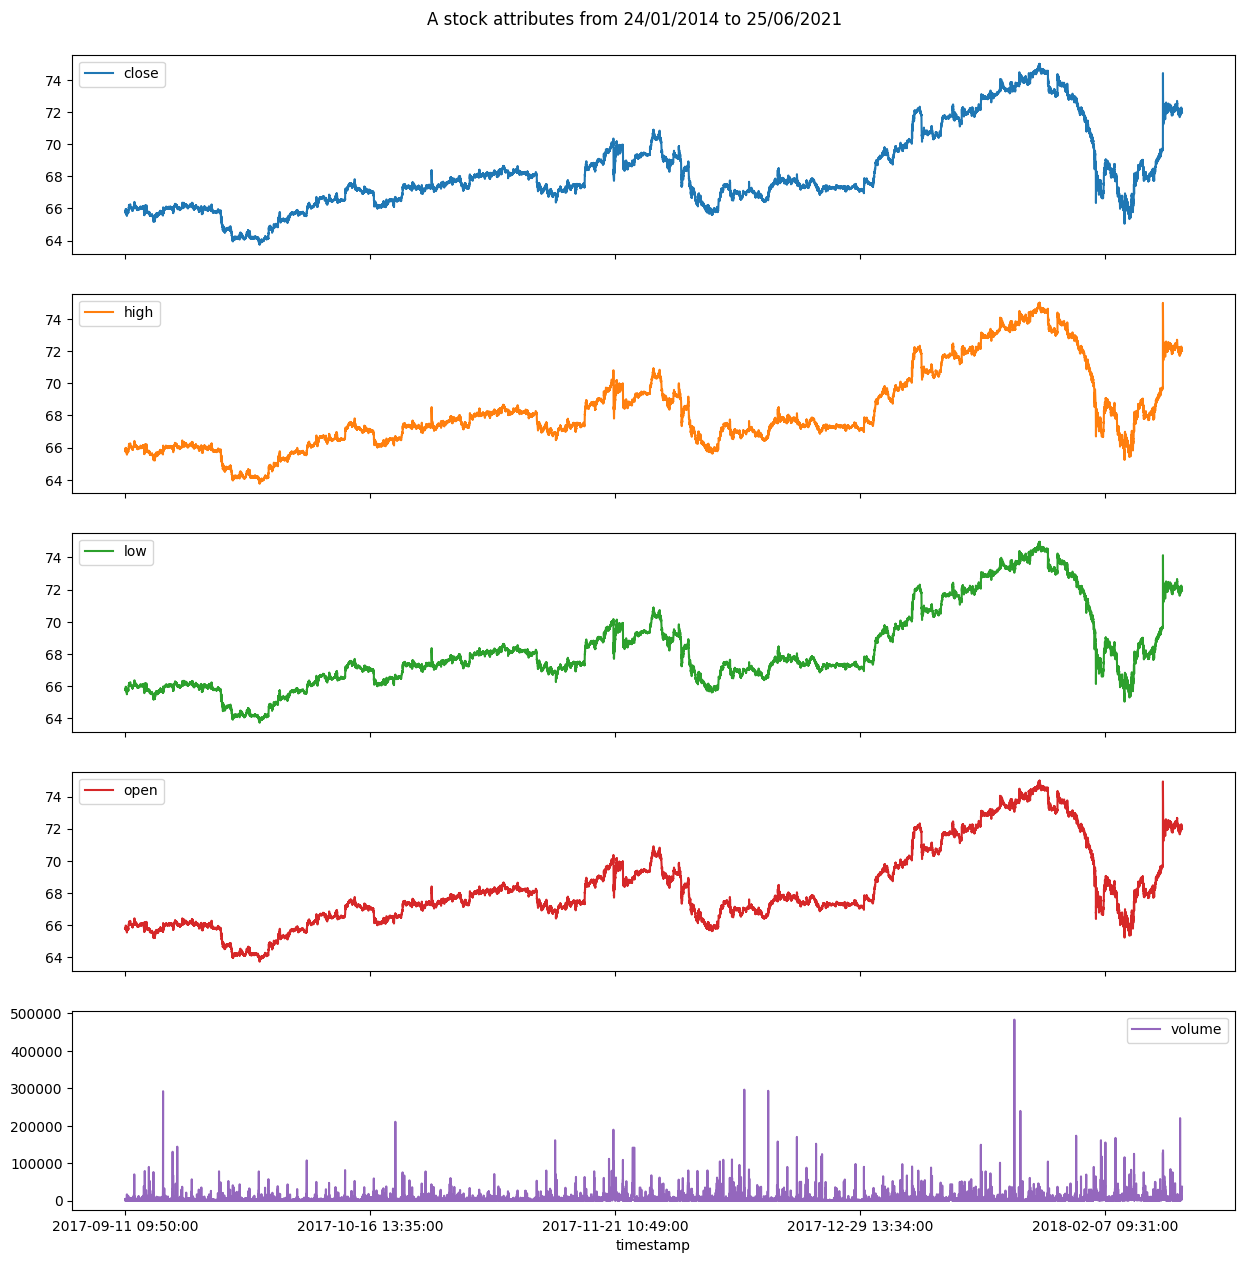

In [166]:
# Stock symbol 'A' behaviour
df1.plot(subplots=True, figsize=(15, 15))
plt.suptitle('A stock attributes from 24/01/2014 to 25/06/2021', y=0.91)
plt.show()

In [167]:
# Split train from  11/09/2017 9:30 A.M. to 17/01/2018 11:50 A.M and test data  from 17/01/2018 11:51A.M. to 16/02/2018 03:59A.M
train = df1.loc['2017-11-12 09:30:00':'2018-01-17 11:50:00']
test = df1.loc['2018-01-17 11:51:00':'2018-02-16 03:59:00']
train.shape

(16700, 5)

In [168]:
# Standardize the data

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Create a function to create sequences of data

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences with a length of 10
seq_length = 11
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Create data loaders
train_data = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
test_data = TensorDataset(torch.tensor(X_test).float(), torch.from_numpy(y_test).float())

batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)


In [169]:
from torch import nn

class VanillaLSTM(nn.Module):
    def __init__(self, num_feature):
        super(VanillaLSTM, self).__init__()
        self.lstm  = nn.LSTM(num_feature,64,batch_first=True)
        self.fc    = nn.Linear(64,num_feature)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

model = VanillaLSTM(5)

In [170]:
# Optiemizer and rmse loss function
import torch.optim as optim

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [171]:
def train(dataloader):
    epoch_loss = 0
    model.train()  
    
    for batch in dataloader:
        optimizer.zero_grad()          
        x,y = batch
        pred = model(x)
        loss = criterion(pred[0],y)        
        loss.backward()               
        optimizer.step()      
        epoch_loss += loss.item()  
        
    return epoch_loss

In [172]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval()  
    
    with torch.no_grad():
      for batch in dataloader:   
          x,y= batch
          pred = model(x)
          loss = criterion(pred[0],y)              
          epoch_loss += loss.item()  
        
    return epoch_loss / len(dataloader)

In [173]:
n_epochs = 600
best_valid_loss = float('inf')

for epoch in range(1, n_epochs + 1):
    train_loss = train(train_loader)
    valid_loss = evaluate(test_loader)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, './checkpoint/saved_weights.pt')

    if (epoch % 200 == 0):
        print(f'\tEpoch: {epoch} | ' + f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

In [ ]:
model=torch.load('./checkpoint/saved_weights.pt')

In [ ]:
X_test = torch.tensor(X_test).float()

with torch.no_grad():
  y_test_pred = model(X_test)

y_test_pred = y_test_pred.numpy()[0]

C:\Users\LT MSI\AppData\Local\Temp\ipykernel_4056\3781883227.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred, multioutput='raw_values'))
mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_test_pred, multioutput='raw_values')
index = ['RMSE','MSE', 'MAE', 'R2 score']

results = pd.DataFrame([rmse, mse, mae, r2], index=index, columns=['close','high','low','open','volume'])
results



,close,high,low,open,volume
RMSE,0.368045,0.358666,0.372851,0.361364,0.970280
MSE,0.135457,0.128641,0.139018,0.130584,0.941442
MAE,0.222934,0.211915,0.226525,0.212792,0.332130
R2 score,0.945999,0.948150,0.945182,0.947941,0.147141


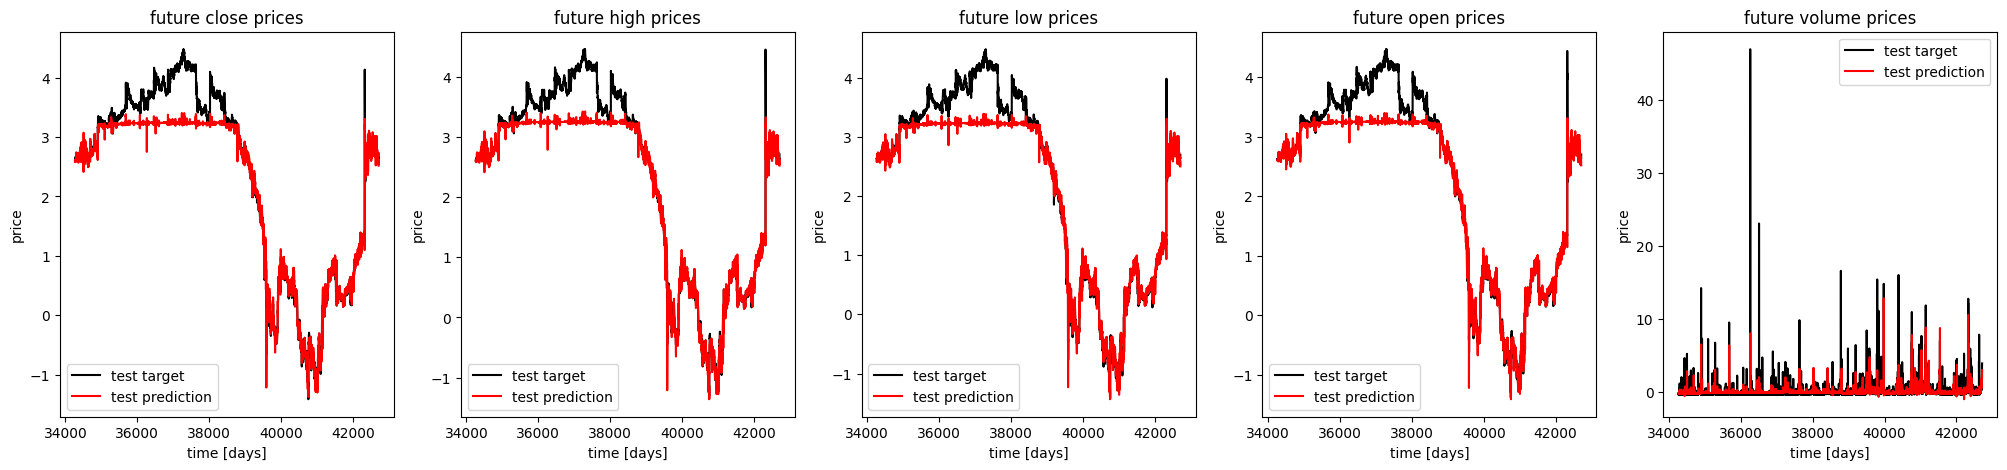

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_figwidth(25)
fig.set_figheight(5)
for i in range(5):
    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,i], color='black', label='test target')

    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,i], color='red', label='test prediction')

    ax[i].set_xlabel('time [days]')
    ax[i].set_ylabel('price')
    ax[i].legend(loc='best')

ax[0].set_title('future close prices')
ax[1].set_title('future high prices')
ax[2].set_title('future low prices')
ax[3].set_title('future open prices')
ax[4].set_title('future volume prices')

plt.show()

In [ ]:
# Predicting the next 10 mins

seq_len = 11
sequences = []
for index in range(len(test) - seq_len + 1): 
    sequences.append(test[index: index + seq_len])
sequences = np.array(sequences)

last_sequence = sequences[-1:, 1:, :]
last_sequence = torch.from_numpy(last_sequence).float()

# Generate predictions
PREDICT = 10
with torch.no_grad():
    for i in range(PREDICT):
        pred_i = model(last_sequence)
        last_sequence = torch.cat((last_sequence, pred_i), dim=1)
        last_sequence = last_sequence[:, 1:, :]


pred_days = last_sequence.reshape(PREDICT, 5).numpy()

# inverse transform the predicted values
pred_days = scaler.inverse_transform(pred_days)

df_pred = pd.DataFrame(
    data=pred_days,
    columns=['<Open>', '<High>', '<Low>', '<Close>', '<Volume>']
)

df_pred

,<Open>,<High>,<Low>,<Close>,<Volume>
0,66.133011,66.253510,66.259407,66.317833,215097.593750
1,68.276031,68.154755,68.314690,68.164543,183199.609375
2,68.115410,68.106659,68.115067,68.165665,193849.031250
3,68.101440,68.120438,68.089798,68.177582,199267.984375
4,68.098099,68.126320,68.085487,68.185265,201192.468750
5,68.148170,68.304794,68.152214,68.386749,182003.343750
6,68.145889,68.401070,68.181274,68.496162,154369.515625
7,68.172066,68.431526,68.203056,68.508156,142697.593750
8,68.250328,68.521568,68.273621,68.584732,142319.125000
9,68.312462,68.589096,68.323929,68.641006,141457.703125


In [ ]:
# df_features = create_features(df_cleaned)

# print('features', df_features.head())

# plot_features(df_features, symbol='A')